In [4]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from lime import lime_image
from skimage.segmentation import mark_boundaries
from pathlib import Path


# Data Preprocessing

In [5]:
# Parameters
IMG_SIZE = 64  # Resize images to 64x64 (can change for different models)
DATASET_DIR = '/Users/ryan/Documents/NUS/Y2S1/IT1244/IT1244_Team 9_Project/Code_Folder/images'

# Function to load images and resize them
def load_images(dataset_dir, img_size):
    images = []
    labels = []
    for filename in os.listdir(dataset_dir):
        if filename.endswith('.png'):
            img_path = os.path.join(dataset_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_size, img_size))  # Resize to the target size
            label = int(filename.split('_')[0])  # Extract class label from filename
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load dataset
X, y = load_images(DATASET_DIR, IMG_SIZE)

# Normalize the images
X = X / 255.0  # Normalizing pixel values to [0,1]

In [6]:
IMG_SIZE = 64  # Resize images to 64x64 (can change for different models)
DATASET_DIR2 = '/Users/ryan/Documents/NUS/Y2S1/IT1244/IT1244_Team 9_Project/Code_Folder/test_set'

# Load dataset
X_new, y_new = load_images(DATASET_DIR2, IMG_SIZE)

# Normalize the images
X_new = X_new / 255.0  # Normalizing pixel values to [0,1]

# Train Test Split

In [7]:
# Split into train (80%) and test set (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 

# Split into train (70%) and validation (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42, stratify=y_train_val) 

# Visualising Class Distribution

In [8]:
# Class distribution for the original dataset
print("Original dataset class distribution:")
print(pd.Series(y).value_counts())

Original dataset class distribution:


NameError: name 'pd' is not defined

# Baseline CNN model

# Default CNN with no augmentation and tuning

In [ ]:
# Build a simple CNN model
def build_cnn_model2(input_shape, num_classes):
    model = Sequential() #  Stack layers one after the other

    model.add(Input(shape=input_shape))
    
    # First Convolutional Layer
    # Learn 32 different features from input 
    # Each filter look at 3x3 patches of the input image
    # Relu -> Non linearity
    model.add(Conv2D(32, (3, 3), activation='relu'))
    # Maxpooling -> Reduces size of feature maps to select the maximum value in each 2x2 region. Reduces computation and focus on the most important features
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Converts the 2D feature maps into a 1D vector
    model.add(Flatten())
    # Network learns from all the features
    model.add(Dense(128, activation='relu'))

    # Convert output into a probability distribution across the classes. 
    # Class with the highest probability is chosen as the predicted class.
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification
    
    return model

In [ ]:
# K-Fold Cross Validation Setup
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Create a list to store the folds
folds = []

# Manually splitting X_train and y_train into k folds
for train_index, val_index in kf.split(X_train_val):
    X_train_fold, X_val_fold = X_train_val[train_index], X_train_val[val_index]
    y_train_fold, y_val_fold = y_train_val[train_index], y_train_val[val_index]
    folds.append((X_train_fold, X_val_fold, y_train_fold, y_val_fold))
    
# Initialize lists to store results
val_accuracies = []
val_losses = []

# Manually run training for each fold
for fold_number in range(k):
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = folds[fold_number]

    cnn_model2 = build_cnn_model2(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=len(np.unique(y)))
    cnn_model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    
    # Train the model using the balanced generator
    history = cnn_model2.fit(X_train_fold, y_train_fold, batch_size=32,epochs=10, validation_data=(X_val_fold, y_val_fold))

    
    val_loss, val_accuracy = cnn_model2.evaluate(X_val_fold, y_val_fold)
    
    # Store the results
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)
    
    print(f'Fold {fold_number} - Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}')

# Calculate average validation accuracy and loss
avg_val_accuracy = np.mean(val_accuracies)
avg_val_loss = np.mean(val_losses)

print(f'Average Validation Accuracy: {avg_val_accuracy:.4f}, Average Validation Loss: {avg_val_loss:.4f}')


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.3237 - loss: 2.3852 - val_accuracy: 0.8061 - val_loss: 0.6739
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8710 - loss: 0.4338 - val_accuracy: 0.9401 - val_loss: 0.2090
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9506 - loss: 0.1600 - val_accuracy: 0.9528 - val_loss: 0.1525
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9839 - loss: 0.0594 - val_accuracy: 0.9592 - val_loss: 0.1311
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9907 - loss: 0.0387 - val_accuracy: 0.9796 - val_loss: 0.0846
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9952 - loss: 0.0171 - val_accuracy: 0.9847 - val_loss: 0.0602
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9999 - loss: 0.0064 - val_accuracy: 0.9860 - val_loss: 0.0685
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9992 - loss: 0.0051 - val_accuracy: 0.9847 - v

# CNN after tuning

In [ ]:
# Use data augmentation to prevent overfitting
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Build a simple CNN model
def build_cnn_model(input_shape, num_classes):
    model = Sequential() #  Stack layers one after the other

    model.add(Input(shape=input_shape))
    
    # First Convolutional Layer
    # Learn 32 different features from input 
    # Each filter look at 3x3 patches of the input image
    # Relu -> Non linearity
    model.add(Conv2D(32, (3, 3), activation='relu'))
    # Maxpooling -> Reduces size of feature maps to select the maximum value in each 2x2 region. Reduces computation and focus on the most important features
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Third convolutional layers
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Converts the 2D feature maps into a 1D vector
    model.add(Flatten())
    # Network learns from all the features
    model.add(Dense(128, activation='relu'))
    # Randomly disables 50% of the neurons in layer during training. 
    # Regularization technique to prevent overfitting by forcing the network not to rely too much on certain features.
    model.add(Dropout(0.5))
    # Convert output into a probability distribution across the classes. 
    # Class with the highest probability is chosen as the predicted class.
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification
    
    return model

In [ ]:
# K-Fold Cross Validation Setup
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Create a list to store the folds
folds = []

# Manually splitting X_train and y_train into k folds
for train_index, val_index in kf.split(X_train_val):
    X_train_fold, X_val_fold = X_train_val[train_index], X_train_val[val_index]
    y_train_fold, y_val_fold = y_train_val[train_index], y_train_val[val_index]
    folds.append((X_train_fold, X_val_fold, y_train_fold, y_val_fold))
    
# Initialize lists to store results
val_accuracies = []
val_losses = []

# Manually run training for each fold
for fold_number in range(k):
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = folds[fold_number]

    cnn_model = build_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=len(np.unique(y)))
    cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    
    # Train the model using the balanced generator
    history = cnn_model.fit(datagen.flow(X_train_fold, y_train_fold, batch_size=32),
                        epochs=10, 
                        validation_data=(X_val_fold, y_val_fold))
    
    val_loss, val_accuracy = cnn_model.evaluate(X_val_fold, y_val_fold)
    
    # Store the results
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)
    
    print(f'Fold {fold_number} - Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}')

# Calculate average validation accuracy and loss
avg_val_accuracy = np.mean(val_accuracies)
avg_val_loss = np.mean(val_losses)

print(f'Average Validation Accuracy: {avg_val_accuracy:.4f}, Average Validation Loss: {avg_val_loss:.4f}')


Epoch 1/10


/Users/ryan/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.1630 - loss: 2.8560 - val_accuracy: 0.3737 - val_loss: 1.8933
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.3637 - loss: 1.9970 - val_accuracy: 0.5497 - val_loss: 1.4899
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.4640 - loss: 1.6303 - val_accuracy: 0.6684 - val_loss: 1.0629
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.5731 - loss: 1.2807 - val_accuracy: 0.7334 - val_loss: 0.7209
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.6369 - loss: 1.0064 - val_accuracy: 0.8635 - val_loss: 0.4875
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.6892 - loss: 0.8409 - val_accuracy: 0.9107 - val_loss: 0.3304
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.7371 - loss: 0.6770 - val_accuracy: 0.9018 - val_loss: 0.2662
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.7664 - loss: 0.6311 - val_accuracy: 0.9375 - val_loss: 0.

# Final Model

In [ ]:
# Compile and train the model
input_shape = (IMG_SIZE, IMG_SIZE, 3)
num_classes = len(np.unique(y))  # Number of classes in the dataset

cnn_model = build_cnn_model(input_shape, num_classes)
# Adam -> combines both Stochastic Gradient Descent and RMSprop optimizers.
#  sparse_categorical_crossentropy -> class is integer-encoded,
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Apply the ImageDataGenerator transformations on the training data
datagen.fit(X_train)

# Compute class weights to overcome imbalanced dataset
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))


history = cnn_model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), class_weight=class_weight_dict)

# history  = cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, class_weight=class_weight_dict)

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.1039 - loss: 3.0476 - val_accuracy: 0.3316 - val_loss: 2.0190
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.4224 - loss: 1.9736 - val_accuracy: 0.7934 - val_loss: 0.7478
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.7193 - loss: 0.9158 - val_accuracy: 0.9337 - val_loss: 0.2708
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8281 - loss: 0.5177 - val_accuracy: 0.9643 - val_loss: 0.1773
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8653 - loss: 0.3943 - val_accuracy: 0.9439 - val_loss: 0.1448
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9019 - loss: 0.3035 - val_accuracy: 0.9719 - val_loss: 0.0783
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9161 - loss: 0.2283 - val_accuracy: 0.9847 - val_loss: 0.0570
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9357 - loss: 0.1667 - val_accu

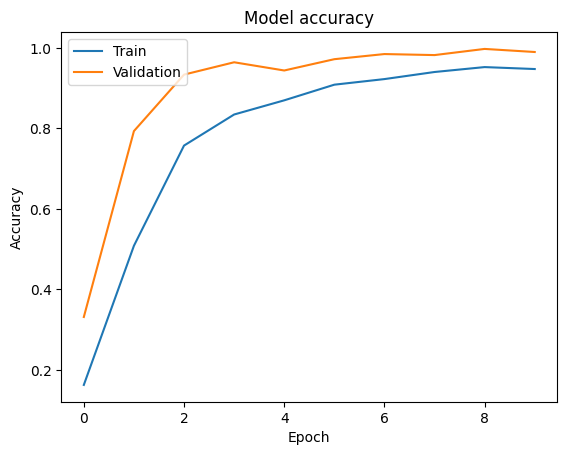

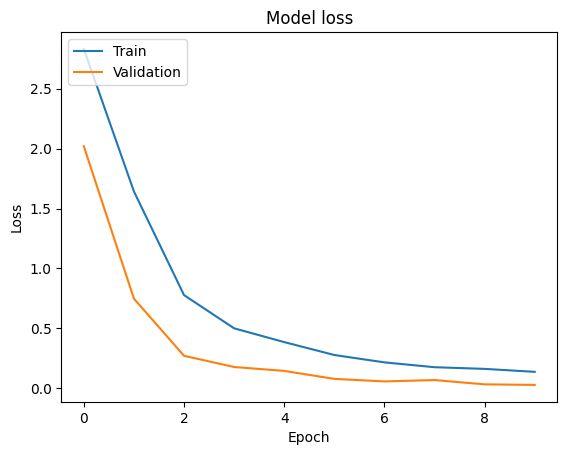

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Confusion matrix

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


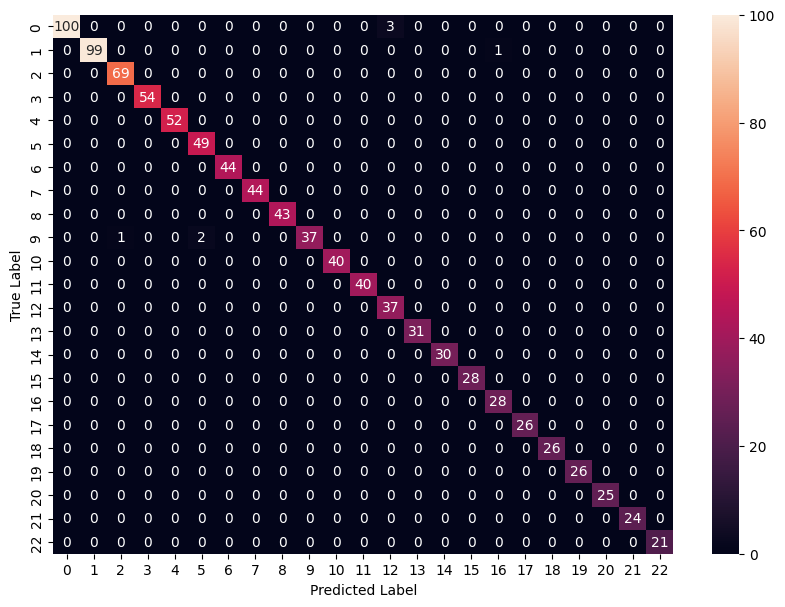

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       103
           1       1.00      0.99      0.99       100
           2       0.99      1.00      0.99        69
           3       1.00      1.00      1.00        54
           4       1.00      1.00      1.00        52
           5       0.96      1.00      0.98        49
           6       1.00      1.00      1.00        44
           7       1.00      1.00      1.00        44
           8       1.00      1.00      1.00        43
           9       1.00      0.93      0.96        40
          10       1.00      1.00      1.00        40
          11       1.00      1.00      1.00        40
          12       0.93      1.00      0.96        37
          13       1.00      1.00      1.00        31
          14       1.00      1.00      1.00        30
          15       1.00      1.00      1.00        28
          16       0.97      1.00      0.98        28
          17       1.00    

In [ ]:
# Predict the test set
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_classes))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


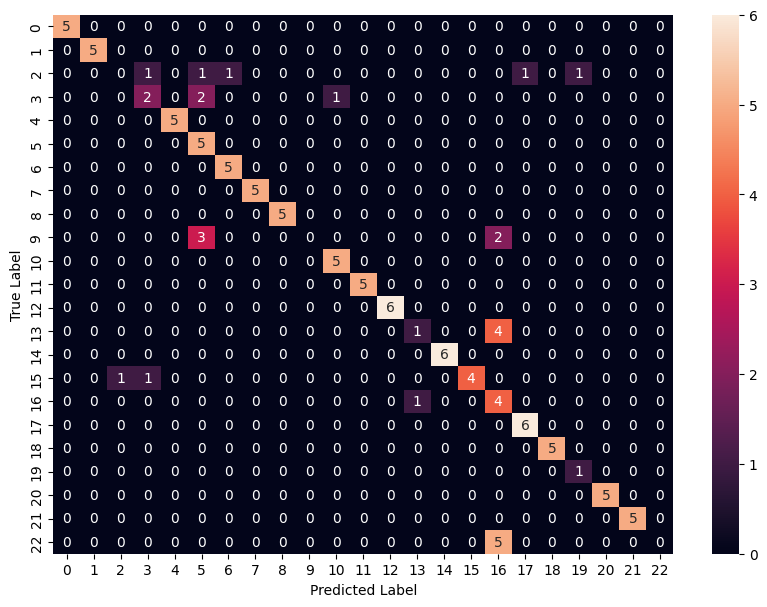

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.00      0.00      0.00         5
           3       0.50      0.40      0.44         5
           4       1.00      1.00      1.00         5
           5       0.45      1.00      0.62         5
           6       0.83      1.00      0.91         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       0.00      0.00      0.00         5
          10       0.83      1.00      0.91         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         6
          13       0.50      0.20      0.29         5
          14       1.00      1.00      1.00         6
          15       1.00      0.67      0.80         6
          16       0.27      0.80      0.40         5
          17       0.86    

/Users/ryan/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryan/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryan/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Predict the test set
y_pred = cnn_model.predict(X_new)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_new, y_pred_classes)

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print(classification_report(y_new, y_pred_classes))

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()
k = 20
# Pick an image from the test set and get the explanation for it
for i in range(k):
    explanation = explainer.explain_instance(X_test[i], cnn_model.predict, top_labels=5, hide_color=0, num_samples=1000)

# Get image and mask for a given label
    temp, mask = explanation.get_image_and_mask(y_test[i], positive_only=True, num_features=5, hide_rest=False)

# Visualize the image explanation
    plt.imshow(mark_boundaries(temp, mask))
    plt.title('LIME Explanation')
    plt.show()


In [ ]:
# Inspect model layers
for layer in cnn_model.layers:
    print(layer.name, layer.output_shape)


AttributeError: 'Conv2D' object has no attribute 'output_shape'

In [ ]:
def get_gradcam(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Assuming `test_img` is a sample image to visualize
heatmap = get_gradcam(cnn_model, X_test[1], "conv2d_2")

# Resize and superimpose heatmap on image
heatmap = cv2.resize(heatmap, (X_test[1].shape[1], X_test[1].shape[2]))
plt.imshow(X_test[1])
plt.imshow(heatmap, cmap='jet', alpha=0.4)  # alpha for transparency
plt.show()


AttributeError: The layer sequential has never been called and thus has no defined output.

/Users/ryan/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 48s 384ms/step - accuracy: 0.2197 - loss: 2.7219 - val_accuracy: 0.8531 - val_loss: 0.6267
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 48s 388ms/step - accuracy: 0.7763 - loss: 0.7695 - val_accuracy: 0.9541 - val_loss: 0.1608
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 47s 385ms/step - accuracy: 0.8961 - loss: 0.3166 - val_accuracy: 0.9796 - val_loss: 0.1026
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 47s 385ms/step - accuracy: 0.9374 - loss: 0.1745 - val_accuracy: 0.9816 - val_loss: 0.1008
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 47s 382ms/step - accuracy: 0.9517 - loss: 0.1524 - val_accuracy: 0.9857 - val_loss: 0.0576
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 47s 383ms/step - accuracy: 0.9683 - loss: 0.1038 - val_accuracy: 0.9857 - val_loss: 0.0632
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 47s 382ms/step - accuracy: 0.9617 - loss: 0.1236 - val_accuracy: 0.9908 - val_loss: 0.0404
Epoch 8/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 48s 386ms/step - accuracy: 0.9741 - loss: 0

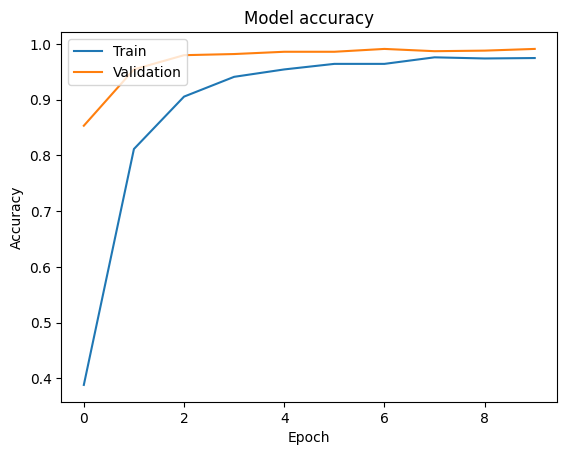

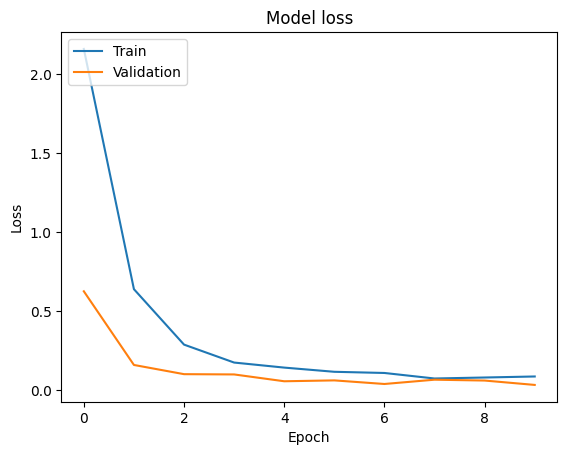

In [ ]:
# Use data augmentation to prevent overfitting
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Build a simple CNN model
def build_cnn_model(input_shape, num_classes):
    model = Sequential() #  Stack layers one after the other
    
    # First Convolutional Layer
    # Learn 32 different features from input 
    # Each filter look at 3x3 patches of the input image
    # Relu -> Non linearity
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    # Maxpooling -> Reduces size of feature maps to select the maximum value in each 2x2 region. Reduces computation and focus on the most important features
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Third convolutional layers
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Converts the 2D feature maps into a 1D vector
    model.add(Flatten())
    # Network learns from all the features
    model.add(Dense(128, activation='relu'))
    # Randomly disables 50% of the neurons in layer during training. 
    # Regularization technique to prevent overfitting by forcing the network not to rely too much on certain features.
    model.add(Dropout(0.5))
    # Convert output into a probability distribution across the classes. 
    # Class with the highest probability is chosen as the predicted class.
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification
    
    return model

# Compile and train the model
input_shape = (IMG_SIZE, IMG_SIZE, 3)
num_classes = len(np.unique(y))  # Number of classes in the dataset

cnn_model = build_cnn_model(input_shape, num_classes)
# Adam -> combines both Stochastic Gradient Descent and RMSprop optimizers.
#  sparse_categorical_crossentropy -> class is integer-encoded,
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# # Augment the data but do not use flow
# datagen.fit(X_train)

# # Compute class weights
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# class_weight_dict = dict(enumerate(class_weights))


# cnn_history  = cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, 
#               validation_data=(X_val, y_val), class_weight=class_weight_dict)

# # Plot training & validation accuracy values
# plt.plot(cnn_history.history['accuracy'])
# plt.plot(cnn_history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(cnn_history.history['loss'])
# plt.plot(cnn_history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

# # Train the model with class weights using .fit()
# cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, 
#               validation_data=(X_test, y_test), class_weight=class_weight_dict)

# Train the model
#cnn_model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=10, validation_data=(X_test, y_test))


# Pretrained model

In [ ]:
# Load a pre-trained model
def build_pretrained_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freezing base model layers
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Compile and train the model
pretrained_model = build_pretrained_model(input_shape, num_classes)
pretrained_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
pretrained_model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=10, validation_data=(X_test, y_test))


## Confusion Matrix

In [ ]:
y_pred2 = pretrained_model.predict(X_test)
y_pred_classes2 = np.argmax(y_pred2, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes2)

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_classes2))